# Landau-Lifshitz-Bloch simulations

Here we calculate the vectorial magnetization dynamic in a magnetic heterostructure employing the mean-field quantum Landau-Lifshitz-Bloch (LLB) apporach. Please read the following review to get an overview of the LLB equation in ultrafast magnetism

U. Atxitia, D. Hinzke, and U. Nowak,  
*Fundamentals and Applications of the Landau-Lifshitz-Bloch Equation*,
[J. Phys. D. Appl. Phys. 50, (2017).](https://doi.org/10.1088/1361-6463/50/3/033003)

Here we need to solve the following differential equation:

\begin{align*}
\frac{d\mathbf{m}}{dt}=\gamma_e \left(\mathbf{m} \times
              \mathbf{H}_\mathrm{eff} + \frac{\alpha_{\perp}}{m^2}\mathbf{m}
              \times (\mathbf{m} \times \mathbf{H}_\mathrm{eff}) -
              \frac{\alpha_{\parallel}}{m^2}(\mathbf{m} \cdot
              \mathbf{H}_\mathrm{eff}) \cdot \mathbf{m}\right)
\end{align*}

The three terms describe

1. **precession** at Larmor frequency,
2. **transversal damping** (conserving the macrospin length), and
3. **longitudinal damping** (changing macrospin length due to incoherent
   atomistic spin excitations within the layer the macrospin is
   defined on).

$\alpha_{\parallel}$ and $\alpha_{\perp}$ are the longitudinal damping and transverse damping parameters, respectively.
$\gamma_e = -1.761\times10^{11}\,\mathrm{rad\,s^{-1}\,T^{-1}}$ is
the gyromagnetic ratio of an electron.

The effective magnetic field is the sum of all relevant magnetic
interactions:

\begin{align*}
    \mathbf{H}_\mathrm{eff} = \mathbf{H}_\mathrm{ext}
      + \mathbf{H}_\mathrm{A}
      + \mathbf{H}_\mathrm{ex}
      + \mathbf{H}_\mathrm{th}
\end{align*}

where

* $\mathbf{H}_\mathrm{ext}$ is the external magnetic field
* $\mathbf{H}_\mathrm{A}$ is the uniaxial anisotropy field
* $\mathbf{H}_\mathrm{ex}$ is the exchange field
* $\mathbf{H}_\mathrm{th}$ is the thermal field

The definitions of these subterms are described in their respective [API documentation](../magnetization.html#udkm1Dsim.simulations.magnetization.LLB).

**The material parameters of the current example arbritarily chosen.**

## Setup

Do all necessary imports and settings.

In [1]:
%load_ext autoreload
%autoreload 2

import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.  
We are providing a magnetization of the atoms which are used as initial magnetization in the LLB simulations, in case no specific initial condition is provided by the user.

In [2]:
Co = ud.Atom('Co', mag_amplitude=1, mag_gamma=0*u.deg, mag_phi=0*u.deg)
Ni = ud.Atom('Ni', mag_amplitude=1, mag_gamma=90*u.deg, mag_phi=0*u.deg)
Fe = ud.Atom('Fe', mag_amplitude=1, mag_gamma=0*u.deg, mag_phi=90*u.deg)
Si = ud.Atom('Si')

Solving the LLB requries several additional parameters of the accoriding `Layer` objects:

* `eff_spin` - effective spin
* `curie_temp` - Curie temperature
* `lamda` - damping parameter (mispelled because of python `lambda`-functions)
* `mag_moment` - atomic magnetic moment
* `aniso_exponent` - exponent of the uniaxial anisotropy
* `anisotropy` - vector of the anisotropy $[K_x, K_y, K_z]$
* `exch_stiffness` - vector of the exchange stiffness $[A_{i\rightarrow (i-1)}, A_{i\rightarrow i}, A_{i\rightarrow (i+1)}]$
* `mag_saturation` - zero temperature saturation magnetization

The correct physical units and more details are documented in the [Layer API](../layers.html#udkm1Dsim.structures.layers.Layer).

In [3]:
prop_Ni = {}
# two-temperture model
prop_Ni['heat_capacity'] = ['0.1*T',
                              532*u.J/u.kg/u.K,
                             ]
prop_Ni['therm_cond'] = [20*u.W/(u.m*u.K),
                           80*u.W/(u.m*u.K),]
g = 4.0e18 # electron-phonon coupling
prop_Ni['sub_system_coupling'] = \
    ['-{:f}*(T_0-T_1)'.format(g),
     '{:f}*(T_0-T_1)'.format(g)
    ]
prop_Ni['lin_therm_exp'] = [0, 11.8e-6]
prop_Ni['opt_ref_index'] = 2.9174+3.3545j

# LLB parameters
prop_Ni['eff_spin'] = 0.5
prop_Ni['curie_temp'] = 630*u.K
prop_Ni['lamda'] = 0.005
prop_Ni['mag_moment'] = 0.393*u.bohr_magneton
prop_Ni['aniso_exponent'] = 3
prop_Ni['anisotropy'] = [0.45e6, 0.45e6, 0.45e6]*u.J/u.m**3
prop_Ni['exch_stiffness'] = [0.1e-15, 1e-15, 0.01e-15]*u.J/u.m
prop_Ni['mag_saturation'] = 500e3*u.J/u.T/u.m**3

# build the layer
layer_Ni = ud.AmorphousLayer('Ni', 'Ni amorphous', thickness=1*u.nm,
                             density=7000*u.kg/u.m**3, atom=Ni, **prop_Ni)

Number of subsystems changed from 1 to 2.


In [4]:
# similar to Ni layer
prop_Co = {}
prop_Co['heat_capacity'] = ['0.1*T',
                              332*u.J/u.kg/u.K,
                             ]
prop_Co['therm_cond'] = [20*u.W/(u.m*u.K),
                           80*u.W/(u.m*u.K),]
g = 5.0e18
prop_Co['sub_system_coupling'] = \
    ['-{:f}*(T_0-T_1)'.format(g),
     '{:f}*(T_0-T_1)'.format(g)
    ]
prop_Co['lin_therm_exp'] = [0, 11.8e-6]
prop_Co['opt_ref_index'] = 2.9174+3.3545j

prop_Co['eff_spin'] = 3
prop_Co['curie_temp'] = 1480*u.K
prop_Co['lamda'] = 0.005
prop_Co['mag_moment'] = 0.393*u.bohr_magneton
prop_Co['aniso_exponent'] = 3
prop_Co['anisotropy'] = [0.45e6, 0.45e6, 0.45e6]*u.J/u.m**3
prop_Co['exch_stiffness'] = [0.2e-15, 2e-15, 0.02e-15]*u.J/u.m
prop_Co['mag_saturation'] = 1400e3*u.J/u.T/u.m**3

layer_Co = ud.AmorphousLayer('Co', 'Co amorphous', thickness=1*u.nm,
                             density=7000*u.kg/u.m**3, atom=Co, **prop_Co)

Number of subsystems changed from 1 to 2.


In [5]:
# similar to Ni layer
prop_Fe = {}
prop_Fe['heat_capacity'] = ['0.1*T',
                              732*u.J/u.kg/u.K,
                             ]
prop_Fe['therm_cond'] = [20*u.W/(u.m*u.K),
                           80*u.W/(u.m*u.K),]
g = 6.0e18
prop_Fe['sub_system_coupling'] = \
    ['-{:f}*(T_0-T_1)'.format(g),
     '{:f}*(T_0-T_1)'.format(g)
    ]
prop_Fe['lin_therm_exp'] = [0, 11.8e-6]
prop_Fe['opt_ref_index'] = 2.9174+3.3545j

prop_Fe['eff_spin'] = 2
prop_Fe['curie_temp'] = 1024*u.K
prop_Fe['lamda'] = 0.005
prop_Fe['mag_moment'] = 2.2*u.bohr_magneton
prop_Fe['aniso_exponent'] = 3
prop_Fe['anisotropy'] = [0.45e6, 0.45e6, 0.45e6]*u.J/u.m**3
prop_Fe['exch_stiffness'] = [0.3e-15, 3e-17, 0.03e-15]*u.J/u.m
prop_Fe['mag_saturation'] = 200e3*u.J/u.T/u.m**3

layer_Fe = ud.AmorphousLayer('Fe', 'Fe amorphous', thickness=1*u.nm,
                             density=7000*u.kg/u.m**3, atom=Fe, **prop_Fe)

Number of subsystems changed from 1 to 2.


In [6]:
# this is the non-magnetic substrate
prop_Si = {}
prop_Si['heat_capacity'] = [100*u.J/u.kg/u.K, 603*u.J/u.kg/u.K]
prop_Si['therm_cond'] = [0, 100*u.W/(u.m*u.K)]

prop_Si['sub_system_coupling'] = [0, 0]

prop_Si['lin_therm_exp'] = [0, 2.6e-6]
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", thickness=1*u.nm, density=2336*u.kg/u.m**3,
                             atom=Si, **prop_Si)

Number of subsystems changed from 1 to 2.


In [7]:
S = ud.Structure('NiCoFeNi')

S.add_sub_structure(layer_Ni, 10)
S.add_sub_structure(layer_Co, 15)
S.add_sub_structure(layer_Fe, 10)
S.add_sub_structure(layer_Ni, 25)
S.add_sub_structure(layer_Si, 200)

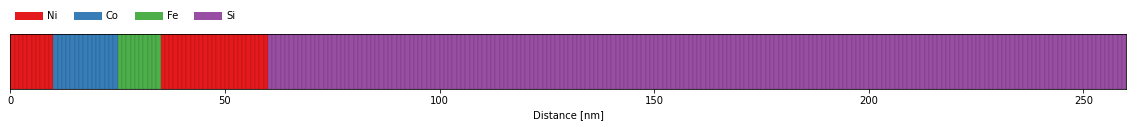

In [8]:
S.visualize()

## Initialize Heat and the Excitation

In [9]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

In [10]:
h.excitation = {'fluence': [25]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0.15]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}
# temporal and spatial grid
delays = np.r_[-10:10:0.05, 10:200:0.5]*u.ps
_, _, distances = S.get_distances_of_layers()

## Calculate Heat Diffusion for 2-Temperature Model

In [11]:
# enable heat diffusion
h.heat_diffusion = True
# set the boundary conditions
h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}
# The resulting temperature profile is calculated in one line:

temp_map, delta_temp = h.get_temp_map(delays, 300)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 46.5 % and transmission of 4.0 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 20.021503 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 34.726814 s
Elapsed time for _temp_map_: 54.925221 s


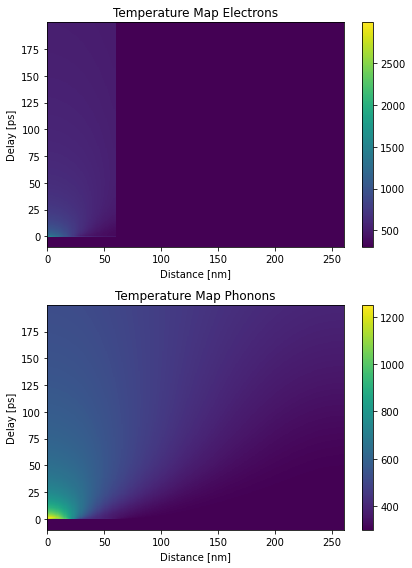

In [12]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 1],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Phonons')

plt.tight_layout()
plt.show()

## Landau-Lifshitz-Bloch Simulations

The `LLB` class requires a `Structure` object and a boolean `force_recalc` in order to overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [13]:
llb = ud.LLB(S, True)

llb.save_data = False
llb.disp_messages = True

print(llb)

Landau-Lifshitz-Bloch Magnetization Dynamics simulation properties:

Magnetization simulation properties:

This is the current structure for the simulations:

Structure properties:

Name   : NiCoFeNi
Thickness : 260.00 nanometer
Roughness : 0.00 nanometer
----
10 times Ni amorphous: 10.00 nanometer
15 times Co amorphous: 15.00 nanometer
10 times Fe amorphous: 10.00 nanometer
25 times Ni amorphous: 25.00 nanometer
200 times Si amorphous: 200.00 nanometer
----
no substrate


Display properties:

================  =======
       parameter  value
================  =======
    force recalc  True
 cache directory  ./
display messages  True
       save data  False
    progress bar  True
================  =======


### Brillouin Function

Internally, the LLB calculates a mean-field magnetization map for the according electron temperatures
$T_e$ at for every layer and for every time step. This done by solving the *Brillouin* function of each
layer and then mapping the result onto the according spatio-temporal grid, as given by the `temp_map`.

In [14]:
mean_field_mag_map = llb.get_mean_field_mag_map(temp_map[:, :, 0])

Calculating _mean_field_magnetization_map_ ...
Elapsed time for _mean_field_magnetization_map_: 1.763555 s


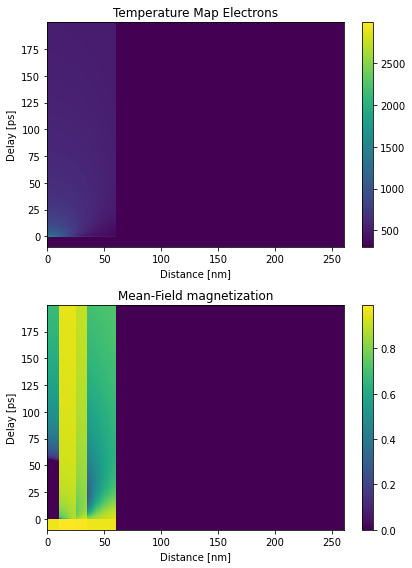

In [15]:
plt.figure(figsize=[6, 8])

plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)

plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, mean_field_mag_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Mean-Field magnetization')

plt.tight_layout()

plt.show()

In order to run the actual LLB simulation, an optional initial magnetization `init_mag` as well as an external magnetic field `H_ext` can be provided.
While `H_ext` is provided in cartesian coordinates $[H_x, H_y, H_z]$ in Tesla, the initial magnetization is given in plolar coordinates $[A, \phi, \gamma]$ in units of [none, rad, rad], following the definitions shown in the [user guide](../user_guide.html#).

Running the simulation is done by calling the `get_magnetization_map` method which requires a `delay` vector as well as the `temp_map`.
The resulting `magnetization_map` is returned in **polar coordinates**.

In [16]:
init_mag = np.array([1.0, (0.*u.deg).to('rad').magnitude, (0*u.deg).to('rad').magnitude])

magnetization_map = llb.get_magnetization_map(delays, temp_map=temp_map, init_mag=init_mag,
                                              H_ext=np.array([0, 0.05, 1]))

Calculating _magnetization_map_ ...
Calculating _mean_field_magnetization_map_ ...
Elapsed time for _mean_field_magnetization_map_: 1.800176 s


0it [00:00, ?it/s]

Elapsed time for _LLB_: 2.235245 s
Elapsed time for _magnetization_map_: 2.237341 s


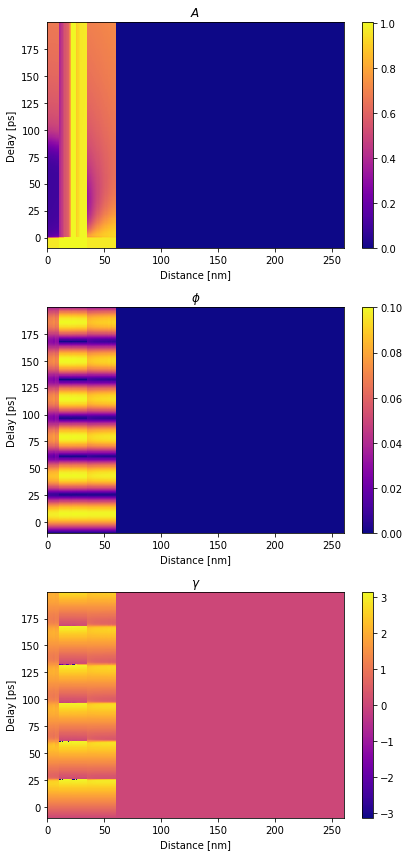

In [17]:
plt.figure(figsize=[6, 12])
plt.subplot(3, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 0],
               shading='auto', cmap='plasma')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$A$')

plt.subplot(3, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 1],
               shading='auto', cmap='plasma')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$\phi$')

plt.subplot(3, 1, 3)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 2],
               shading='auto', cmap='plasma')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$\gamma$')

plt.tight_layout()
plt.show()

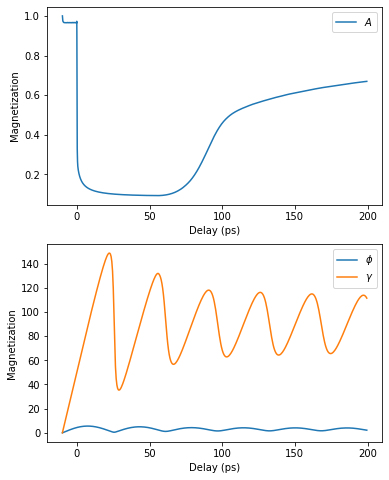

In [18]:
plt.figure(figsize=[6,8])
plt.subplot(2,1,1)
plt.plot(delays, np.mean(magnetization_map[:, 0:10, 0], axis=1), label=r'$A$')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.subplot(2,1,2)
plt.plot(delays, (np.mean(magnetization_map[:, 0:10, 1], axis=1)*u.rad).to('deg'), label=r'$\phi$')
plt.plot(delays, (np.mean(magnetization_map[:, 0:10, 2], axis=1)*u.rad).to('deg'), label=r'$\gamma$')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.show()

The `magnetization` class provides helper methods to convert the result also into cartesian coordinates:

In [19]:
magnetization_map_xyz = ud.LLB.convert_polar_to_cartesian(magnetization_map)

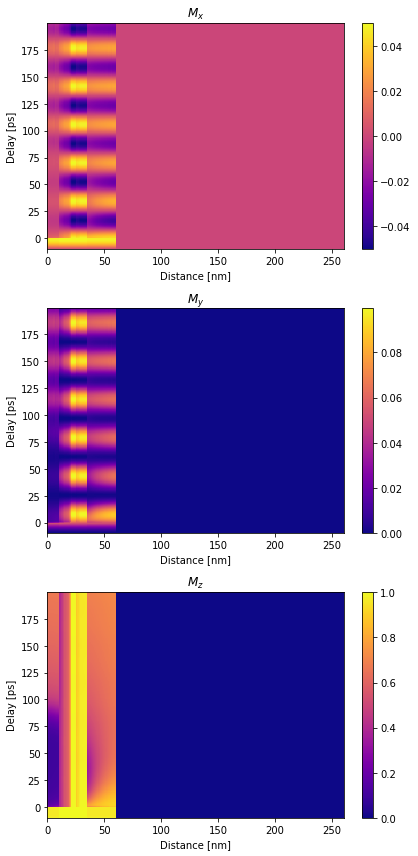

In [20]:
plt.figure(figsize=[6, 12])
plt.subplot(3, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map_xyz[:, :, 0],
               shading='auto', cmap='plasma')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$M_x$')

plt.subplot(3, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map_xyz[:, :, 1],
               shading='auto', cmap='plasma')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$M_y$')

plt.subplot(3, 1, 3)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map_xyz[:, :, 2],
               shading='auto', cmap='plasma')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$M_z$')

plt.tight_layout()
plt.show()

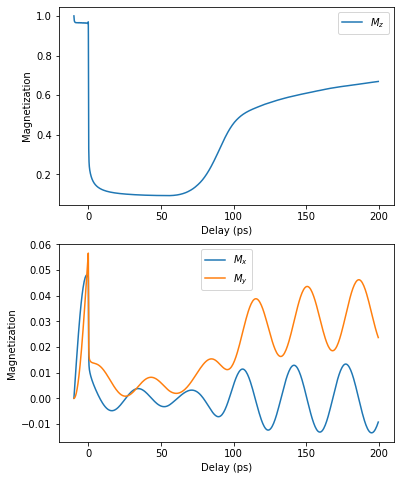

In [21]:
plt.figure(figsize=[6,8])
plt.subplot(2,1,1)
plt.plot(delays, np.mean(magnetization_map_xyz[:, 0:10, 2], axis=1), label=r'$M_z$')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.subplot(2,1,2)
plt.plot(delays, np.mean(magnetization_map_xyz[:, 0:10, 0], axis=1), label=r'$M_x$')
plt.plot(delays, np.mean(magnetization_map_xyz[:, 0:10, 1], axis=1), label=r'$M_y$')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.show()

In both plot it is obvious, that the magnetization already starts to change before the actual laser excitation raises the electronic temperatures.
This is because of the misalignment of the initial magnetization and the external magnetic field.
To avoid this, the steady-state solution of the layer magnetization must be found first and used as `init_mag` for the actual transient simulations.